# Data Analysis Task

## Background:
### Discovery (and other teams within the Foundation) rely on event logging (EL) to track a variety of performance and usage metrics to help us make decisions. Specifically, Discovery is interested in:

### - clickthrough rate: the proportion of search sessions where the user clicked on one of the results displayed
### - zero results rate: the proportion of searches that yielded 0 results

## Exploratory Analysis:
### The first step to start this analysis is to understand the data provided and import the necessary packages.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from statistics import mean
import numpy as np

In [2]:
#df = pd.read_csv(r'/Users/jdanieldavilah/Desktop/ADEVINTA/events_log.csv')

In [3]:
# To read the csv, the original file has been split into 3 and stored on Github
# it is necessary to read the 3 files and concat them. 
# first csv
url1 =  'https://raw.githubusercontent.com/jdanieldavilah/Adevinta_Test/main/events_log1.csv'
raw_df1 = pd.read_csv(url1,index_col=0)
# second csv
url2 =  'https://raw.githubusercontent.com/jdanieldavilah/Adevinta_Test/main/events_log2.csv'
raw_df2 = pd.read_csv(url2,index_col=0)
# third csv
url3 =  'https://raw.githubusercontent.com/jdanieldavilah/Adevinta_Test/main/events_log3.csv'
raw_df3 = pd.read_csv(url3,index_col=0)
# unify the dataframes
frames = [raw_df1, raw_df2, raw_df3]
df = pd.concat(frames)

In [4]:
df.head()

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position
0,00000736167c507e8ec225bd9e71f9e5,2.016030e+13,78245c2c3fba013a,b,searchResultPage,NaN,cbeb66d1bc1f1bc2,5.0,NaN
1,00000c69fe345268935463abbfa5d5b3,2.016031e+13,c559c3be98dca8a4,a,searchResultPage,NaN,eb658e8722aad674,10.0,NaN
2,00003bfdab715ee59077a3670331b787,2.016030e+13,760bf89817ce4b08,a,checkin,30.0,f99a9fc1f7fdd21e,NaN,NaN
3,0000465cd7c35ad2bdeafec953e08c1a,2.016030e+13,fb905603d31b2071,a,checkin,60.0,e5626962a6939a75,NaN,10.0
4,000050cbb4ef5b42b16c4d2cf69e6358,2.016030e+13,c2bf5e5172a892dc,a,checkin,30.0,787dd6a4c371cbf9,NaN,NaN


In [5]:
len(df)

400165

In [6]:
df.dtypes

uuid                object
timestamp          float64
session_id          object
group               object
action              object
checkin            float64
page_id             object
n_results          float64
result_position    float64
dtype: object

describe() was used as part of the exploratory analysis to understand volumes, means, percentiles and deviations.

In [7]:
df.describe()

,timestamp,checkin,n_results,result_position
count,4.001650e+05,223824.000000,136234.000000,230482.000000
mean,2.016030e+13,97.190382,13.210109,2.992798
std,2.340996e+06,104.593714,13.271104,38.557292
min,2.016030e+13,10.000000,0.000000,1.000000
25%,2.016030e+13,20.000000,2.000000,1.000000
50%,2.016030e+13,50.000000,20.000000,1.000000
75%,2.016031e+13,150.000000,20.000000,2.000000
max,2.016031e+13,420.000000,500.000000,4103.000000


isna().sum() was used to determine the number of nulls per column in the dataset.

In [8]:
df.isna().sum()

uuid                    0
timestamp               0
session_id              0
group                   0
action                  0
checkin            176341
page_id                 0
n_results          263931
result_position    169683
dtype: int64

Similarly, isnull() was used to identify the number of cases where the values in all the three columns 'checkin', 'n_results' and 'result_position' were null.

In [9]:
len(df.loc[(df['checkin'].isnull()) 
           & (df['n_results'].isnull()) 
           & (df['result_position'].isnull())])

6028

Finally we can check the amount of searches, visits and checkins by counting the values in the action column

In [10]:
df.action.value_counts()

checkin             223824
searchResultPage    136234
visitPage            40107
Name: action, dtype: int64

# TASK 1: 
### What is our daily overall clickthrough rate? How does it vary between the groups?

In order to estimate the overall clickthrough rate, we need to estimate the proportion of the search session where there is at least one visitPage.

In [11]:
print( 'number of sessions: ' + str(len(df.session_id.unique())) )
print( 'number of sessions with at least one visitPage: ' + str(len(df.loc[df.action == 'visitPage'].session_id.unique())) )
print('overall clickthrough rate: ' + str( (len(df.loc[df.action == 'visitPage'].session_id.unique())) / (len(df.session_id.unique())) ) )

number of sessions: 68028
number of sessions with at least one visitPage: 26452
overall clickthrough rate: 0.3888398894572823


### The overall clickthrough rate is 0.3888, however, since we want this ratio to be estimated daily, we need to re-estimate it by date and then average the daily rate.

The first step is to have the timestamps in a proper format so that it can be used to group by date:

In [12]:
# Convert the initial timestamp into the datetime format
df['timestamp_correct'] = df.apply(lambda x: datetime.datetime.strptime(str(x['timestamp'])[0:12], '%Y%m%d%H%M%S'), axis=1)

In [13]:
# Extract only the date which can be useful to analyze the daily data
df['date'] = df['timestamp_correct'].dt.date

Then we can estimate the sessions and sessions with visitPage per day, divide them to calculate the daily ratio and finally find the mean:

In [14]:
# Estimate total sessions and total sessions with one visitPage per day
sessions = df.sort_values(['date'])[['date','session_id']].groupby('date').session_id.nunique().tolist()
sessions_with_visitPage = df.sort_values(['date']).loc[df.action == 'visitPage'][['date','session_id']].groupby('date').session_id.nunique().tolist()
# Zip both list to estimate the ratio
zip(sessions, sessions_with_visitPage)
mean([x / y for x, y in zip(sessions_with_visitPage, sessions)])

0.3884540193323712

### The overall daily clickthrough rate is 0.3884, slightly below the overall.
### The next step is to compare the ratio by groups:
We can use the same methodology but doing the estimation individually for each group

In [15]:
sessions_A = df.sort_values(['date']).loc[df.group == 'a'][['date','session_id']].groupby('date').session_id.nunique().tolist()
sessions_with_visitPage_A = df.sort_values(['date']).loc[(df.action == 'visitPage') & (df.group == 'a')][['date','session_id']].groupby('date').session_id.nunique().tolist()
zip(sessions_A, sessions_with_visitPage_A)
mean([x / y for x, y in zip(sessions_with_visitPage_A, sessions_A)])

0.6678010206288028

In [16]:
sessions_B = df.sort_values(['date']).loc[df.group == 'b'][['date','session_id']].groupby('date').session_id.nunique().tolist()
sessions_with_visitPage_B = df.sort_values(['date']).loc[(df.action == 'visitPage') & (df.group == 'b')][['date','session_id']].groupby('date').session_id.nunique().tolist()
zip(sessions_B, sessions_with_visitPage_B)
mean([x / y for x, y in zip(sessions_with_visitPage_B, sessions_B)])

0.1755471224373909

### As we can see, the average daily clickthrough rate is higher for the group A (0.67) than the group B (0.18) and the overall ratio (0.39)
We can visualize the variation by group and day to have a better understanding of the difference:

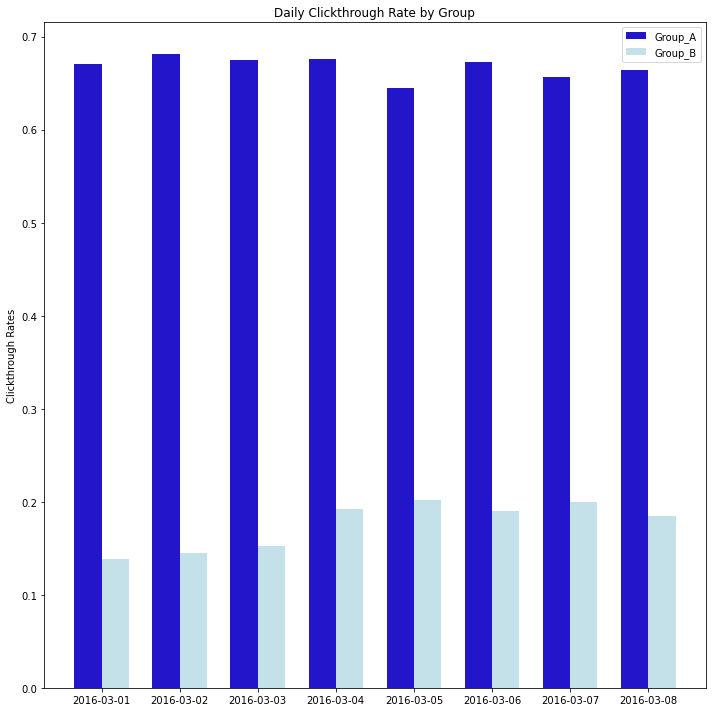

In [17]:
# Set the list of items needed for the plot
days = df.sort_values(['date'])['timestamp_correct'].dt.date.astype(str).unique()
A_means = [x / y for x, y in zip(sessions_with_visitPage_A, sessions_A)]
B_means = [x / y for x, y in zip(sessions_with_visitPage_B, sessions_B)]

x = np.arange(len(days))  # the labels location
width = 0.35  # the width of the bars

# Plot setup
fig, ax = plt.subplots( figsize=(10,10))
rects1 = ax.bar(x - width/2, A_means, width, label='Group_A' , color='#2315c9')
rects2 = ax.bar(x + width/2, B_means, width, label='Group_B' , color='#c4e1e9')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Clickthrough Rates')
ax.set_title('Daily Clickthrough Rate by Group')
ax.set_xticks(x)
ax.set_xticklabels(days)
ax.legend()

fig.tight_layout()
plt.show()

### Insights:
### - Group_A's Daily Clickthrough Rate is consistently above Group_B's.
### - While the Group_A Ratio seems to be stable, that of Group_B is increasing, however, it is far from that of Group_A. 

# TASK 2: 
### Which results do people tend to try first? How does it change day-to-day?
In order to detect the results that people tend to try first, we need to check which result_position usually gets the first visit per session.

To detect this, we can create a summary data frame where we initially store the first visit of each session and merge it with the original to extract the result_position that matches this timestamp.

In [18]:
# Step 1: create the summary df
df_first_visit = df.loc[df['action']=='visitPage'][['session_id','timestamp_correct']].groupby(['session_id']).min()

In [19]:
# Step 2: add the result_position data
df_first_visit =  pd.merge(df_first_visit 
                            , df.loc[df['action']=='visitPage'][['session_id','timestamp_correct','result_position','date']]
                            , how="left" 
                            , on=["session_id", "timestamp_correct"]
                           )

In [20]:
df_first_visit.result_position.value_counts().head(10)

1.0     17963
2.0      3841
3.0      1952
4.0      1037
5.0       611
6.0       460
7.0       286
8.0       191
9.0       150
10.0      139
Name: result_position, dtype: int64

### As expected, people tend to visit the results in the order that they appear, thus, being the 'result_position' 1 the most visited in the first try, with a 65% of the total first visits recorded, followed by the positions 2, 3.

### We can chek too if this is a common trend by day:

In [21]:
# We can estimate the mode per day (the most common result selected as the first option)
df_first_visit[['date','result_position']].groupby('date')['result_position'].agg(pd.Series.mode)

date
2016-03-01    1.0
2016-03-02    1.0
2016-03-03    1.0
2016-03-04    1.0
2016-03-05    1.0
2016-03-06    1.0
2016-03-07    1.0
2016-03-08    1.0
Name: result_position, dtype: float64

### We can confirm that the most common result selected as the first option per day is still the one with 'result_position' = 1

# TASK 3: 
### What is our daily overall zero results rate? How does it vary between the groups?

We can start by estimating the overall zero results rate:

In [22]:
# The ratio of searches with no results to the total number of searches
len(df.loc[ (df['n_results'] == 0) & (df['action'] == 'searchResultPage') ]) / len(df.loc[df['action'] == 'searchResultPage'])

0.18444000763392399

### The Overall Zero Results Rate is 0.1844

Now we can estimate the same ratio by day: 

In [23]:
# First estimate of total searches and total searches with no results per day
searches = df.loc[ (df['action'] == 'searchResultPage')].sort_values(['date'])[['date','session_id']].groupby('date').size().tolist()
searches_0 = df.loc[ (df['n_results'] == 0) & 
                    (df['action'] == 'searchResultPage')].sort_values(['date'])[['date','session_id']].groupby('date').size().tolist()
# Zip both list to estimate the ratio
zip(searches, searches_0)
mean([x / y for x, y in zip(searches_0, searches)])

0.18435118300165268

### The Daily Overall Zero Results Rate is 0.1843
Finally we can estimate this for each group to understand its variation:

In [24]:
searches_A = df.loc[(df['action'] == 'searchResultPage') & 
                    (df['group'] == 'a')].sort_values(['date'])[['date','session_id']].groupby('date').size().tolist()
searches_0_A = df.loc[ (df['n_results'] == 0) & 
                      (df['action'] == 'searchResultPage') &
                      (df['group'] == 'a')].sort_values(['date'])[['date','session_id']].groupby('date').size().tolist()
zip(searches_A, searches_0_A)
mean([x / y for x, y in zip(searches_0_A, searches_A)])

0.18312908076338574

In [25]:
searches_B = df.loc[(df['action'] == 'searchResultPage') & 
                    (df['group'] == 'b')].sort_values(['date'])[['date','session_id']].groupby('date').size().tolist()
searches_0_B = df.loc[ (df['n_results'] == 0) & 
                      (df['action'] == 'searchResultPage') &
                      (df['group'] == 'b')].sort_values(['date'])[['date','session_id']].groupby('date').size().tolist()
zip(searches_B, searches_0_B)
mean([x / y for x, y in zip(searches_0_B, searches_B)])

0.1865176631583894

### The Daily Overall Zero Results Rate of the Group_A (0.1831) is below the overall ratio (0.1843) and the Group_B's  (0.1865)
As in task A, we can visualize the variation by group and day to better understand the difference:

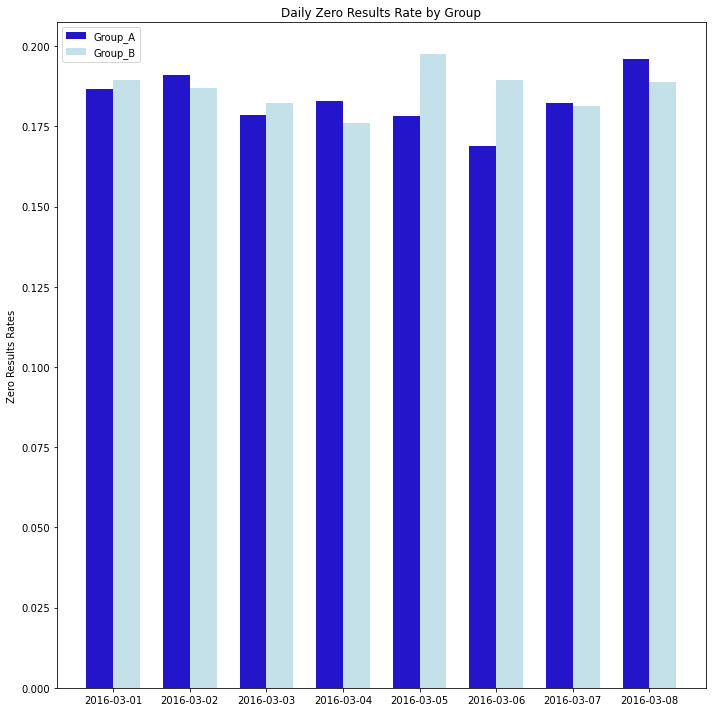

In [26]:
# Set the list of items needed for the plot
days = df.sort_values(['date'])['timestamp_correct'].dt.date.astype(str).unique()
A_means = [x / y for x, y in zip(searches_0_A, searches_A)]
B_means = [x / y for x, y in zip(searches_0_B, searches_B)]

x = np.arange(len(days))  # the labels location
width = 0.35  # the width of the bars

# Plot setup
fig, ax = plt.subplots( figsize=(10,10))
rects1 = ax.bar(x - width/2, A_means, width, label='Group_A' , color='#2315c9')
rects2 = ax.bar(x + width/2, B_means, width, label='Group_B' , color='#c4e1e9')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Zero Results Rates')
ax.set_title('Daily Zero Results Rate by Group')
ax.set_xticks(x)
ax.set_xticklabels(days)
ax.legend()

fig.tight_layout()
plt.show()

### The above plot shows how there are some days where the Zero Results Rate is actually higher in Group_A (opposite to what the overall rate shows). The reason why the overall ratio of Group_B is higher is mainly due to a large increase recorded on days 05 and 06.

# TASK 4: 
### Let session length be approximately the time between the first event and the last event in a session. Choose a variable from the dataset and describe its relationship to session length. Visualize the relationship.
We can start creating the session length feature for each session: 

In [27]:
# Step 1: Create a data frame with the first and last events per session
df_lenght = df[['session_id','timestamp_correct']].groupby(['session_id']).agg({'timestamp_correct': [ 'min', 'max']}).reset_index()
# Step 2: Estimate the session_length & clean the df
df_lenght['session_length'] = (df_lenght.iloc[:, 2]-df_lenght.iloc[:, 1]).astype('timedelta64[s]')
df_structure = {'session_id': df_lenght.iloc[:, 0], 'first_event': df_lenght.iloc[:, 1], 'max_event': df_lenght.iloc[:, 2], 'session_length': df_lenght.iloc[:, 3]}
df_lenght = pd.DataFrame(data=df_structure)
# Step 3: Merge the session_length data with the main df
df =  pd.merge(df 
               , df_lenght[['session_id','session_length']]
               , how="left" 
               , on=["session_id"]
              )

We have created the session_length metric in seconds for greater accuracy when analyzing its relationship to other features. 

Using the df_length dataframe created above, we can analyze the distribution of session_length

In [28]:
# Check the new metric distribution
df_lenght['session_length'].describe()

count     68028.000000
mean        150.992885
std        2279.231914
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max      507354.000000
Name: session_length, dtype: float64

Based on the values returned by the describe() function, we can see that there is a big difference between the quantile 0.75 and the max, which may be due to the presence of large outliers in the sample.

Checking different quantiles over the 0.75 and plotting a histogram can help us better understand the distribution of the feature:

In [29]:
print( 'quantile 80: ' +  str(df_lenght['session_length'].quantile(0.80)))
print( 'quantile 85: ' +  str(df_lenght['session_length'].quantile(0.85)))
print( 'quantile 90: ' +  str(df_lenght['session_length'].quantile(0.90)))
print( 'quantile 95: ' +  str(df_lenght['session_length'].quantile(0.95)))
print( 'quantile 96: ' +  str(df_lenght['session_length'].quantile(0.96)))
print( 'quantile 975: ' +  str(df_lenght['session_length'].quantile(0.975)))
print( 'quantile 99: ' +  str(df_lenght['session_length'].quantile(0.99)))

quantile 80: 7.0
quantile 85: 54.0
quantile 90: 57.0
quantile 95: 63.0
quantile 96: 117.91999999999825
quantile 975: 3296.0
quantile 99: 3301.0


We can already see that after the 96th quantile there is a jump in the value of session_length, and there is another jump from the 0.99th quantile to the max.

We can now plot some histograms to visualize these jumps in the overall distribution:

/Users/jdanieldavilah/miniconda3/envs/firstEnv/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='session_length', ylabel='Density'>

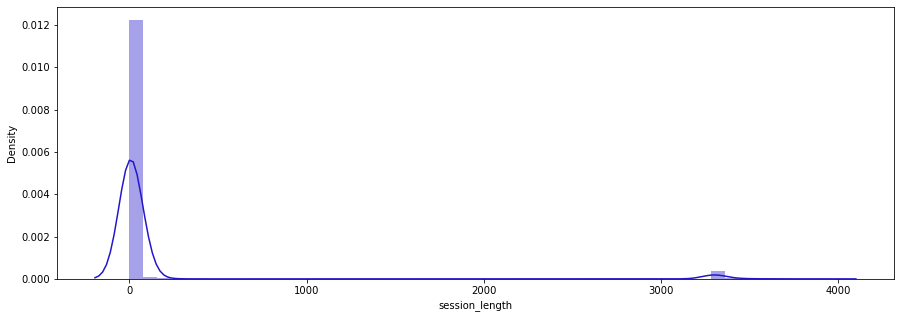

In [30]:
plt.figure(figsize=(15, 5))
sns.distplot(df_lenght.loc[df_lenght.session_length < 5000]['session_length'], color="#2315c9")

We can see in this plot the two clearly differentiated groups, the first group of sessions with a duration below 120 seconds, and the other that is around 3300 seconds.

We can zoom in on the largest group that is the shortest in length to understand its distribution:

/Users/jdanieldavilah/miniconda3/envs/firstEnv/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='session_length', ylabel='Density'>

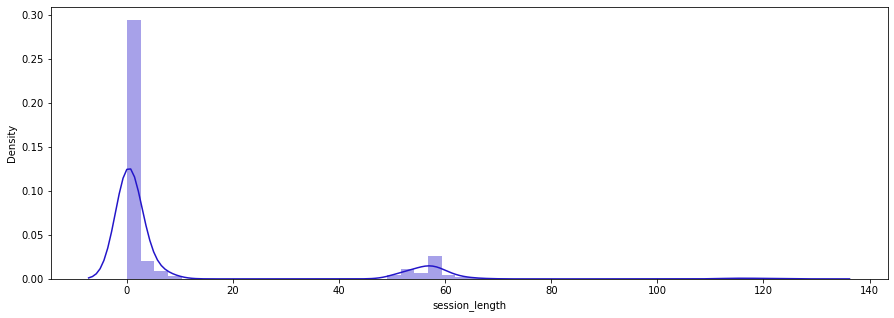

In [31]:
plt.figure(figsize=(15, 5))
sns.distplot(df_lenght.loc[df_lenght.session_length < 150]['session_length'], color="#2315c9")

### We can observe that even within this subgroup there are some jumps in the sample distribution, with a group with sessions of almost no duration and a second group of sessions that lasted around one minute
Taking into account the subgroups detected, it could be interesting to check the percentage of sessions included in the three most representative:
1. with a duration of less than 10 seconds
2. lasting about a minute
3. with a duration of around 3300 seconds

In [32]:
print( len(df_lenght.loc[df_lenght.session_length <= 10]) / len( df_lenght) )
print( len(df_lenght.loc[ (df_lenght.session_length >= 40) & (df_lenght.session_length <= 70) ]) / len( df_lenght) )
print( len(df_lenght.loc[ (df_lenght.session_length >= 3100) & (df_lenght.session_length <= 3500) ]) / len( df_lenght) )

0.8143705533015817
0.14098606456165108
0.0330893161639325


### We can see that these 3 groups include more than 90% of the sessions.  
### Once we have analyzed the nature of the feature, we can now compare it with other variables in the dataset, in this case the column action,  and focus on two possible relationships:
### - Whether the number of searches executed or the number of pages visited correlates in any way with the length of sessions.
### - if there is any relationship between the duration of a session and the number of results that appeared on the searchResultPage.
The first step is to create a dataframe where we can compare for each session, its duration, the total number of results taking into account all searches, and the total number of registered visits:

In [33]:
# Estimate the number of search results and visits individually
n_searches_df = df.loc[(df['action'] == 'searchResultPage')][['session_id' ,'session_length' , 'action']].groupby(
    ['session_id']).agg({'session_length' : 'mean' , 'action' : 'count'}).reset_index()

n_visits_df = df.loc[(df['action'] == 'visitPage')][['session_id' , 'session_length' , 'action']].groupby(
    ['session_id']).agg({'session_length' : 'mean' , 'action' : 'count'}).reset_index()

n_results_df = df.loc[(df['action'] == 'searchResultPage')][['session_id' ,'session_length' , 'n_results']].groupby(
    ['session_id']).agg({'session_length' : 'mean' , 'n_results' : 'sum'}).reset_index()

# Unify dataframes and change column names
lenght_comparison_df =  pd.merge(n_searches_df 
               , n_results_df
               , how='left' 
               , on=['session_length' , 'session_id']
              )
lenght_comparison_df = lenght_comparison_df.rename(columns={lenght_comparison_df.columns[2]: 'n_searches'})

lenght_comparison_df =  pd.merge(lenght_comparison_df 
               , n_visits_df 
               , how='left' 
               , on=['session_length' , 'session_id']
              )
lenght_comparison_df = lenght_comparison_df.rename(columns={lenght_comparison_df.columns[4]: 'n_visits'})

We can do some data cleaning to fill in the null values in the n_visits feature created by the join:

In [34]:
#Fill n_visits == NaN with 0 visits
lenght_comparison_df['n_visits'] = lenght_comparison_df['n_visits'].fillna(0)

We can check the distribution of these new metrics in the subsample created using describe()

In [35]:
lenght_comparison_df.describe()

,session_length,n_searches,n_results,n_visits
count,67951.000000,67951.000000,67951.000000,67951.000000
mean,150.711675,2.004886,26.484761,0.589130
std,2280.231403,3.443526,50.755222,1.244703
min,0.000000,1.000000,0.000000,0.000000
25%,0.000000,1.000000,8.000000,0.000000
50%,0.000000,1.000000,20.000000,0.000000
75%,3.000000,2.000000,28.000000,1.000000
max,507354.000000,484.000000,5600.000000,75.000000


Since there is a large difference between the 0.75th percentile and the maximum across all features there are likely to be some outliers in the sample, which we can detect by checking the distribution at the highest percentiles.

In [36]:
print( 'n_searches quantile 0.975: ' +  str(lenght_comparison_df.n_searches.quantile(0.975)))
print( 'n_results quantile 0.975: ' +  str(lenght_comparison_df.n_results.quantile(0.975)))
print( 'n_visits quantile 0.975: ' +  str(lenght_comparison_df.n_visits.quantile(0.975)))

n_searches quantile 0.975: 7.0
n_results quantile 0.975: 100.0
n_visits quantile 0.975: 3.0


And we can see from the above results, that there are some big outliers that are likely to distort the analysis, and we can exclude them to have a better understanding of the relationship of the metrics.

Now we can check the correlation of session_length with the rest of the features:

<AxesSubplot:>

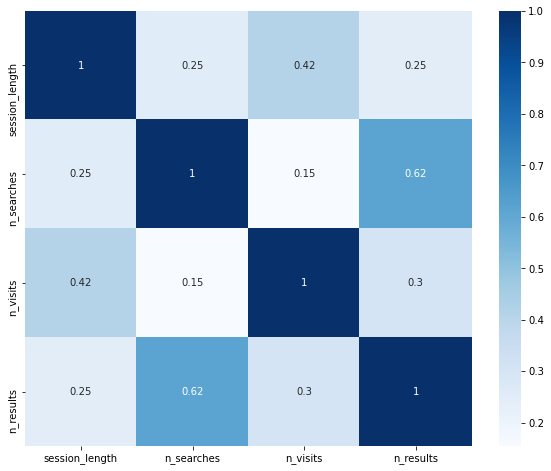

In [37]:
plt.figure(figsize=(10, 8))
sns.heatmap(lenght_comparison_df.loc[
    (lenght_comparison_df.session_length <= 150) &
    (lenght_comparison_df.n_searches <= 7) &
    (lenght_comparison_df.n_results <= 100) &
    (lenght_comparison_df.n_visits <= 3) 
][['session_length' , 'n_searches' , 'n_visits' , 'n_results']].corr(), annot=True, cmap='Blues')

### As we can see in the correlation plot, none of the evaluated variables is highly correlated with the session_lenght, with the number of visits being the one with the strongest relationship (0.41), which means that sometimes having more visits can increase the duration of the session, but not all the time.

### Similarly, there is no linear trend between session_length and the other two features, so performing more searches or returning more results on those searches does not necessarily mean the session lasts longer.

We can finally check the correlations with the three main groups detected in the session_length distribution plot:

<AxesSubplot:>

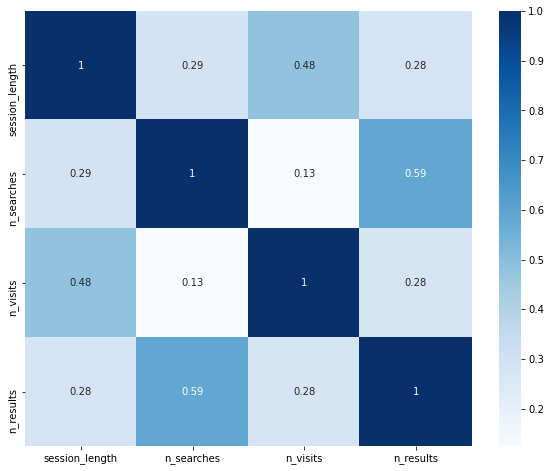

In [38]:
# Group of sessions of almost no duration
plt.figure(figsize=(10, 8))
sns.heatmap(lenght_comparison_df.loc[
    (lenght_comparison_df.session_length <= 10) &
    (lenght_comparison_df.n_searches <= 7) &
    (lenght_comparison_df.n_results <= 100) &
    (lenght_comparison_df.n_visits <= 3) 
][['session_length' , 'n_searches' , 'n_visits' , 'n_results']].corr(), annot=True, cmap='Blues')

This group is where features are most correlated to session_length, with the number of visits showing a medium correlation with the session length

<AxesSubplot:>

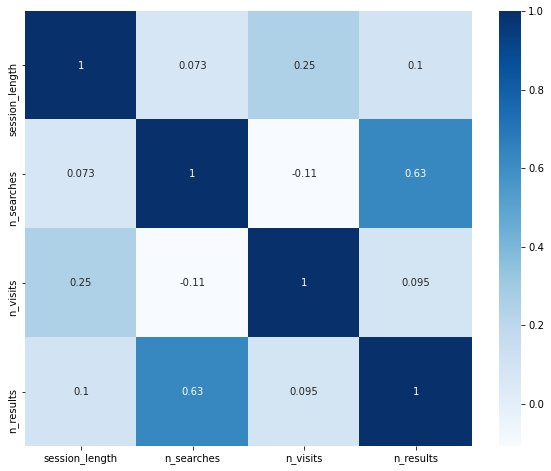

In [39]:
# Group of sessions that lasted around one minute
plt.figure(figsize=(10, 8))
sns.heatmap(lenght_comparison_df.loc[
    (lenght_comparison_df.session_length < 70) &
    (lenght_comparison_df.session_length > 40) &
    (lenght_comparison_df.n_searches <= 7) &
    (lenght_comparison_df.n_results <= 100) &
    (lenght_comparison_df.n_visits <= 3) 
][['session_length' , 'n_searches' , 'n_visits' , 'n_results']].corr(), annot=True, cmap='Blues')

In this group the features evaluated are less correlated to session_length than the previous one. 

<AxesSubplot:>

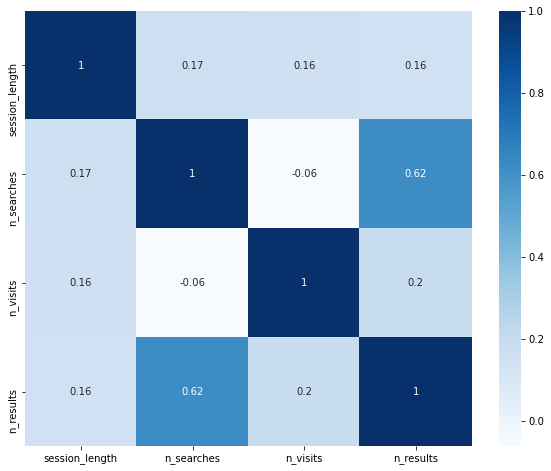

In [40]:
# Group of sessions that lasted around one hour
plt.figure(figsize=(10, 8))
sns.heatmap(lenght_comparison_df.loc[
    (lenght_comparison_df.session_length < 3500) &
    (lenght_comparison_df.session_length > 3100) &
    (lenght_comparison_df.n_searches <= 7) &
    (lenght_comparison_df.n_results <= 100) &
    (lenght_comparison_df.n_visits <= 3) 
][['session_length' , 'n_searches' , 'n_visits' , 'n_results']].corr(), annot=True, cmap='Blues')

In this group all features are equally correlated to session_length.

### We can conclude that:
### - None of the evaluated variables is highly correlated with session_length
### - The longer the session lasts, the more the relationship between these variables varies and the correlation is weaker
### - Number of visits being the one with the strongest relationship (0.42 overall and 0.48 for short sessions)

# TASK 5: 
### Summarize your findings in an executive summary.
A copy of this summary will be available on github in pdf format.

### EXECUTIVE SUMMARY
# Users Behavior during the search - Analysis 

### Background
This analysis was done for the general purpose of helping the Discovery Team understand how users behave regarding their searches on the platform and what specific actions they tend to take during the time they spend on the page. The study was carried out considering the data of eight days, starting on 03-01-2016 and ending on 03-08-2016, and evaluating two groups of users, 'Group A' and 'Group B'. During this period, a total of 136234 searches were performed and 40107 pages were visited from these searches.

### Analysis Focus
For this review, the Discovery Team was specifically interested in looking at two metrics:
1. Clickthrough Rate: the proportion of search sessions where the user clicked on one of the results displayed.
2. Zero Results Rate: the proportion of searches that yielded 0 results.

Some other metrics and actions evaluated in the analysis are the searches and pages visited from the searches, the search results that people tend to try first and the duration of the sessions.

### Methodology
The analysis was carried out following the questions, priorities and concerns of the Discovery Team, considering one task at a time, however its results can be divided into two sections for a better understanding:
1. Monitoring of Main Metrics: the performance of the Clickthrough Rate and the Zero Results Rate, were analyzed by groups and by day to understand their trends and patterns. 
2. Evaluation of Secondary Metrics: The other metrics were analyzed with the aim of understanding both their individual behavior and the relationship between them.

### Main Insights
1. The Daily Overall Clickthrough Rate was 0.39 which seems like a low ratio; however, when considering the groups, we can see that Group_A performed considerably better (0.67) and consistently over the days. On the other hand, the low Group_B ratio (0.18) had a negative impact on the general metric, despite having increased in recent days.
2. The Daily Overall Zero Results was 0.18 and had a similar performance in both groups, with the ratio of Group_B slightly higher due to a large increase recorded on days 05 and 06.
3. Neither the number of searches, nor the pages visited nor the search results determine the duration of a session or vice versa. Only the number of pages visited showed any relationship to session duration, however, the longer the session, the weaker the correlation with visits and other metrics.
4. More than 90% of the sessions can be grouped by their duration into three groups: Those that end in 10 seconds or less, those that last around a minute and those that remain active for around an hour.
5. The number of visits is also not correlated with the number of searches or with the number of results displayed. In 65% of the time the user visited at least one page, the user clicked on the first search result. People actually tend to visit the results in the order that they appear.  

### Final thoughts and next steps
In general, Group A performs better in the main metrics evaluated during the eight days monitored. We will have to investigate the reasons for Group_B's poor performance.
Having detected the three groups of sessions (according to it duration) it will be interesting to confirm if there is any link between them and the two main groups evaluated(A and B). 
Since pageviews are the goal of search, the focus should not be on having longer sessions, or displaying more search results, but on optimizing rankings to display the best products in the top positions.
